# MTA Challenges: Pandas

## Solve Challenges using Pandas in order to facilitate project Benson 

### Mitchell Lee: July 12, 2017

#### Import usful packages and set pandas preferences

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.precision', 3)

#### Define some usful functions

In [2]:
def clean_cols(df):
    for col in df.columns:
        # Clean the string type data
        if df[col].dtype == 'object':
            df[col]= df[col].str.strip()
    return df

def make_standard_names(df):
    # Clean up the column names
    cols = df.columns
    for col in cols:
        col_new = col
        col_new = col_new.lower()
        col_new = col_new.strip()
        col_new = col_new.replace('/','')
        col_new = col_new.replace(' ','_')
        df = df.rename(columns = {col: col_new})
    return df

def make_id(df):
    df['id'] = df['ca']+'_'+ df['unit'] +'_'+df['scp']+'_'+df['station']
    return df

# Question 1

In [3]:
# Get a list of files
flist = glob.glob('turnstile*.txt')
#flist.sort(reverse=True)
flist.sort()
flist

['turnstile_170603.txt',
 'turnstile_170610.txt',
 'turnstile_170617.txt',
 'turnstile_170624.txt',
 'turnstile_170701.txt',
 'turnstile_170708.txt']

In [4]:
# Open dataframe and run simple clean ups
nyc_df = pd.read_csv(flist[-1])

In [5]:
# Create a unique "Meter Name"
# 'ca', 'unit','scp' comprise a unique "meters".
# There can be several "meters" at each station. 
# This these can be recombined using "Group By"

def clean_up(df):
    df = clean_cols(df)
    df = make_standard_names(df)
    df = make_id(df)
    
    # Make datetime column
    df['readtime'] = df['date'] + ' ' + df['time']
    df['readtime'] = pd.to_datetime(df['readtime'], format='%m/%d/%Y %H:%M:%S')
    
    
    # Remove Audit Hours
    df = df[df['desc'] != 'RECOVR AUD']

    # Calculate riders entering and exiting for each hour
    df['entries_diff'] = df['entries'].diff()
    df['exits_diff'] = df['exits'].diff()

    # Filter out "impossible values"
    lower_lim = 0
    upper_lim = 60*60*4 # One rider per second for 4 hours

    # Clean up jump that results in diff when going from one meter to another
    # To do this, I converted the "ids", exits, and entries to lists, and the I
    # I used a simple "for loop".
    id_list = list(df['id'])
    entries_diff_list = list(df.entries_diff)
    exits_diff_list = list(df.exits_diff)

    for ix, val in enumerate(id_list):
        if ix!= 0:
            if id_list[ix]!= id_list[ix-1]:
                entries_diff_list[ix] = np.nan
                exits_diff_list[ix] = np.nan

    for ix, val in enumerate(entries_diff_list):
        if val> upper_lim:
            entries_diff_list[ix] = np.nan
        elif val<0:
            entries_diff_list[ix] = np.nan

    for ix, val in enumerate(exits_diff_list):
        if val> upper_lim:
            exits_diff_list[ix] = np.nan
        elif val<0:
            exits_diff_list[ix] = np.nan

    # Put cleaned values back in the data frame

    df['entries_diff_cleaned'] = entries_diff_list
    df['exits_diff_cleaned'] = exits_diff_list
    df['total_traffic'] = df['entries_diff_cleaned'] + df['exits_diff_cleaned'] 
    
    return df


In [6]:
nyc_df = clean_up(nyc_df)

In [7]:
turnstile_grouped = nyc_df.groupby('id')
turnstile_grouped.sum()[10:20]
#turnstile_grouped.median()

,entries,exits,entries_diff,exits_diff,entries_diff_cleaned,exits_diff_cleaned,total_traffic
id,,,,,,,
A002_R051_02-05-01_59 ST,0,34086,-1.413e+03,7.410e+02,0.0,0.0,0.0
A002_R051_02-06-00_59 ST,327107804,6972932,7.116e+06,1.509e+05,7630.0,149.0,7779.0
A006_R079_00-00-00_5 AV/59 ST,122240169,208521893,-4.200e+06,4.821e+06,8471.0,13867.0,22338.0
A006_R079_00-00-01_5 AV/59 ST,173407634,109017445,1.218e+06,-2.375e+06,7721.0,4296.0,12017.0
A006_R079_00-00-02_5 AV/59 ST,229157791,679385413,1.326e+06,1.358e+07,5738.0,2406.0,8144.0
A006_R079_00-00-03_5 AV/59 ST,100317632,37092791,-3.068e+06,-1.529e+07,4792.0,1691.0,6483.0
A006_R079_00-00-04_5 AV/59 ST,298368679,131073595,4.716e+06,2.238e+06,4930.0,1856.0,6786.0
A006_R079_00-03-00_5 AV/59 ST,352308183,156451424,1.285e+06,6.045e+05,6356.0,2307.0,8663.0
A006_R079_00-03-01_5 AV/59 ST,102314438,54134445,-5.951e+06,-2.435e+06,8119.0,4862.0,12981.0


# Question 2

In [8]:
turnstile_time_grouped = nyc_df.groupby(['id','readtime'])
turnstile_time_grouped.mean().iloc[0:10]

entries    exits  entries_diff  \
id                       readtime                                              
A002_R051_02-00-00_59 ST 2017-07-01 00:00:00  6241669  2113493           NaN   
                         2017-07-01 04:00:00  6241693  2113495          24.0   
                         2017-07-01 08:00:00  6241706  2113522          13.0   
                         2017-07-01 12:00:00  6241794  2113615          88.0   
                         2017-07-01 16:00:00  6241992  2113666         198.0   
                         2017-07-01 20:00:00  6242258  2113707         266.0   
                         2017-07-02 00:00:00  6242391  2113725         133.0   
                         2017-07-02 04:00:00  6242425  2113728          34.0   
                         2017-07-02 08:00:00  6242442  2113753          17.0   
                         2017-07-02 12:00:00  6242507  2113825          65.0   

                                              exits_diff  \
id                       readtime                          
A002_R051_02-00-00_59 ST 2017-07-01 00:00:00         NaN   
                         2017-07-01 04:00:00         2.0   
                         2017-07-01 08:00:00        27.0   
                         2017-07-01 12:00:00        93.0   
                         2017-07-01 16:00:00        51.0   
                         2017-07-01 20:00:00        41.0   
                         2017-07-02 00:00:00        18.0   
                         2017-07-02 04:00:00         3.0   
                         2017-07-02 08:00:00        25.0   
                         2017-07-02 12:00:00        72.0   

                                              entries_diff_cleaned  \
id                       readtime                                    
A002_R051_02-00-00_59 ST 2017-07-01 00:00:00                   NaN   
                         2017-07-01 04:00:00                  24.0   
                         2017-07-01 08:00:00                  13.0   
                         2017-07-01 12:00:00                  88.0   
                         2017-07-01 16:00:00                 198.0   
                         2017-07-01 20:00:00                 266.0   
                         2017-07-02 00:00:00                 133.0   
                         2017-07-02 04:00:00                  34.0   
                         2017-07-02 08:00:00                  17.0   
                         2017-07-02 12:00:00                  65.0   

                                              exits_diff_cleaned  \
id                       readtime                                  
A002_R051_02-00-00_59 ST 2017-07-01 00:00:00                 NaN   
                         2017-07-01 04:00:00                 2.0   
                         2017-07-01 08:00:00                27.0   
                         2017-07-01 12:00:00                93.0   
                         2017-07-01 16:00:00                51.0   
                         2017-07-01 20:00:00                41.0   
                         2017-07-02 00:00:00                18.0   
                         2017-07-02 04:00:00                 3.0   
                         2017-07-02 08:00:00                25.0   
                         2017-07-02 12:00:00                72.0   

                                              total_traffic  
id                       readtime                            
A002_R051_02-00-00_59 ST 2017-07-01 00:00:00            NaN  
                         2017-07-01 04:00:00           26.0  
                         2017-07-01 08:00:00           40.0  
                         2017-07-01 12:00:00          181.0  
                         2017-07-01 16:00:00          249.0  
                         2017-07-01 20:00:00          307.0  
                         2017-07-02 00:00:00          151.0  
                         2017-07-02 04:00:00           37.0  
                         2017-07-02 08:00:00           42.0  
                        

# Question 3

n = ~4

In [9]:
turnstile_date_grouped = nyc_df.groupby(['ca','unit','scp','station','date'])
turnstile_date_summed = turnstile_date_grouped.sum().dropna()

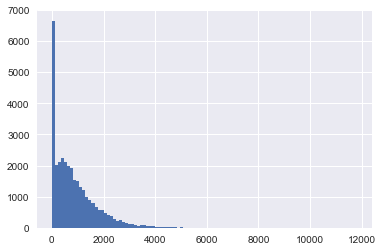

In [10]:
plt.hist(turnstile_date_summed['entries_diff_cleaned'],bins = 100)
plt.show()

In [11]:
turnstile_date_summed

entries     exits  \
ca    unit scp      station       date                             
A002  R051 02-00-00 59 ST         07/01/2017  37451112  12681498   
                                  07/02/2017  37455331  12682810   
                                  07/03/2017  37459533  12684396   
                                  07/04/2017  37465039  12685871   
                                  07/05/2017  56203584  19031260   
...                                                ...       ...   
TRAM2 R469 00-05-01 RIT-ROOSEVELT 07/01/2017     33324      1809   
                                  07/02/2017     33324      1812   
                                  07/03/2017     22216      1208   
                                  07/04/2017     33324      1812   
                                  07/05/2017     27770      1510   

                                              entries_diff  exits_diff  \
ca    unit scp      station       date                                   
A002  R051 02-00-00 59 ST         07/01/2017         589.0       214.0   
                                  07/02/2017         629.0       201.0   
                                  07/03/2017         998.0       314.0   
                                  07/04/2017         595.0       176.0   
                                  07/05/2017        1331.0       475.0   
...                                                    ...         ...   
TRAM2 R469 00-05-01 RIT-ROOSEVELT 07/01/2017        2862.0       240.0   
                                  07/02/2017           0.0         0.0   
                                  07/03/2017           0.0         0.0   
                                  07/04/2017           0.0         0.0   
                                  07/05/2017           0.0         0.0   

                                              entries_diff_cleaned  \
ca    unit scp      station       date                               
A002  R051 02-00-00 59 ST         07/01/2017                 589.0   
                                  07/02/2017                 629.0   
                                  07/03/2017                 998.0   
                                  07/04/2017                 595.0   
                                  07/05/2017                1331.0   
...                                                            ...   
TRAM2 R469 00-05-01 RIT-ROOSEVELT 07/01/2017                   0.0   
                                  07/02/2017                   0.0   
                                  07/03/2017                   0.0   
                                  07/04/2017                   0.0   
                                  07/05/2017                   0.0   

                                              exits_diff_cleaned  \
ca    unit scp      station       date                             
A002  R051 02-00-00 59 ST         07/01/2017               214.0   
                                  07/02/2017               201.0   
                                  07/03/2017               314.0   
                                  07/04/2017               176.0   
                                  07/05/2017               475.0   
...                                                          ...   
TRAM2 R469 00-05-01 RIT-ROOSEVELT 07/01/2017                 1.0   
                                  07/02/2017                 0.0   
                                  07/03/2017                 0.0   
                                  07/04/2017                 0.0   
                                  07/05/2017                 0.0   

                                              total_traffic  
ca    unit scp      station       date                       
A002  R051 02-00-00 59 ST         07/01/2017          803.0  
                                  07/02/2017          830.0  
                                  07/03/2017         1312.0  
                                  07/04/2017          771.0  
                               

# Question 4
#### Plot the daily time series for a turnstile.

In [12]:
# matplotlib import and set up done at top of file

# Reset index to make querying easier
turnstile_date_summed = turnstile_date_summed.reset_index()
turnstile_date_summed = make_id(turnstile_date_summed)

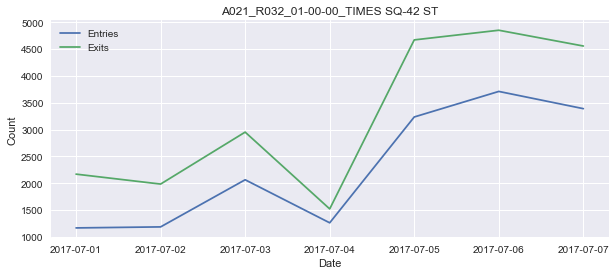

In [13]:
test_turnstile = turnstile_date_summed['id'][420]

single_turnstile = turnstile_date_summed[turnstile_date_summed['id'] == test_turnstile]

fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(pd.to_datetime(single_turnstile['date']),single_turnstile['entries_diff_cleaned'])
plt.plot(pd.to_datetime(single_turnstile['date']),single_turnstile['exits_diff_cleaned'])
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(['Entries','Exits'])
plt.title(test_turnstile)

In [14]:
#turnstile_date_summed[turnstile_date_summed['id'].str.contains('42')]

# Question 5
#### Group by ControlArea/Unit/Station (i.e. substation)

In [15]:
substation_date_summed = turnstile_date_summed.groupby(['ca','unit','station']).sum()
substation_date_summed

,,,entries,exits,entries_diff,exits_diff,entries_diff_cleaned,exits_diff_cleaned,total_traffic
ca,unit,station,,,,,,,
A002,R051,59 ST,2549405278,1204083191,8.740e+05,-1.962e+06,68859.0,40537.0,109396.0
A006,R079,5 AV/59 ST,1980843413,1998049043,7.242e+06,1.467e+07,57295.0,41799.0,99094.0
A007,R079,5 AV/59 ST,5683213803,536107727,-8.002e+06,-1.238e+07,31873.0,22182.0,54055.0
A010,R080,57 ST-7 AV,3414996352,1047851418,2.142e+07,3.212e+06,95396.0,32145.0,127541.0
A011,R080,57 ST-7 AV,72623100901,60331732360,-9.865e+08,-4.560e+08,47332.0,44643.0,91975.0
...,...,...,...,...,...,...,...,...,...
S101,R070,ST. GEORGE,718742399,960582,-1.559e+09,-1.728e+09,30747.0,0.0,30747.0
S101A,R070,ST. GEORGE,4222572051,3249288,-1.301e+06,-2.200e+02,32482.0,0.0,32482.0
S102,R165,TOMPKINSVILLE,390492781,104182596,-4.120e+02,0.000e+00,4207.0,0.0,4207.0


# Question 6
#### Group by station

There are many many duplicate stations in new york city.
i.e. there are several stations called 125th street

According to:
https://data.ny.gov/Transportation/Turnstile-Usage-Data-2016/ekwu-khcy/about, 'unit' is the true eqivalent of a station. Thus I am going to use groupby(unit,station,date) to get daily data aggregated by station.

In [16]:
station_date_summed = turnstile_date_summed.groupby(['unit','station','date']).sum().reset_index()

# Question 7
#### Plot timeseries for a single station

In [17]:
#station_date_summed[station_date_summed['station'].str.contains('125')]

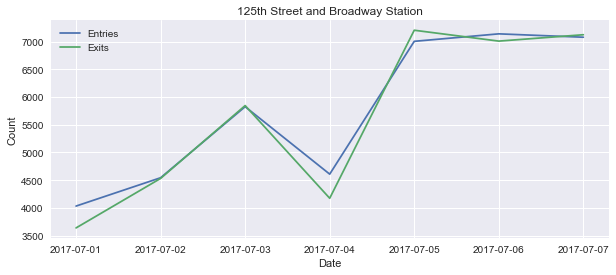

In [18]:
# According to http://web.mta.info/developers/resources/nyct/turnstile/Remote-Booth-Station.xls
# I used to live near the 'Unit = R034' station

mitch_rows = (station_date_summed['unit'] == 'R034') & (station_date_summed['station'] == '125 ST')
mitch_station = station_date_summed.loc[(mitch_rows)]

fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(pd.to_datetime(mitch_station['date']),mitch_station['entries_diff_cleaned'])
plt.plot(pd.to_datetime(mitch_station['date']),mitch_station['exits_diff_cleaned'])
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(['Entries','Exits'])
plt.title('125th Street and Broadway Station')

# Question 8

Make one list of counts for one week for one station. Monday's count, Tuesday's count, etc. so it's a list of 7 counts. Make the same list for another week, and another week, and another week. plt.plot(week_count_list) for every week_count_list you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.

---
All previous code was written assuming that I was working with one week.  Time to go back and "functionalize" previous work so that I can reuse it.

In [108]:
# loop through downloaded turnstile file
# This might take awhile
for ix, fname in enumerate(flist):
    new_df = pd.read_csv(fname)
    new_df_cleaned = clean_up(new_df)
    
    if ix == 0:
        station_daily = new_df_cleaned.groupby(['unit','station','date']).sum().reset_index()
    else:
        station_daily = station_daily.append(
            new_df_cleaned.groupby(['unit','station','date']).sum().reset_index(),ignore_index=True)

In [109]:
# Date Time Handeling 
station_daily['dtime'] = pd.to_datetime(station_daily['date'])
station_daily['week'] = station_daily['dtime'].dt.week
station_daily['day'] = station_daily['dtime'].dt.dayofweek

weeks = station_daily['week'].unique()

In [110]:
# Investigate 125th St and Broadway station again
mitch_rows2 = (station_daily['unit'] == 'R034') & (station_daily['station'] == '125 ST')
mitch_station2 = station_daily.loc[(mitch_rows2)]

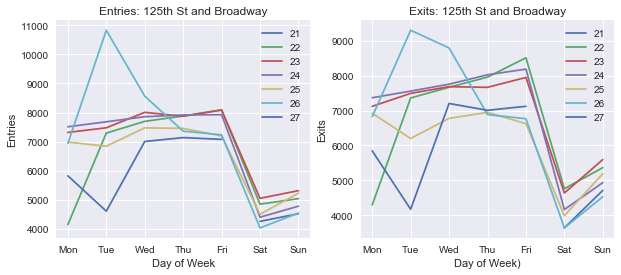

In [111]:
def make_rainbow_plot(df,title):
    fig, ax = plt.subplots(1,2, figsize=(10, 4))

    # Entries
    for w in weeks:
        week_df = df[df['week'] == w]
        ax[0].plot(week_df.day,week_df.entries_diff_cleaned)

    ax[0].set_title('Entries: ' + title)
    ax[0].set_xlabel('Day of Week')
    ax[0].set_ylabel('Entries')
    ax[0].set_xticks(range(0,7))
    ax[0].set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
    ax[0].legend(weeks)

    # Exits 
    for w in weeks:
        week_df = df[df['week'] == w]
        ax[1].plot(week_df.day,week_df.exits_diff_cleaned)

    ax[1].set_title('Exits: ' + title)
    ax[1].set_xlabel('Day of Week)')
    ax[1].set_ylabel('Exits')
    ax[1].set_xticks(range(0,7))
    ax[1].set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
    ax[1].legend(weeks)
    
make_rainbow_plot(mitch_station2,'125th St and Broadway')

# Question 9

Over multiple weeks, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate

---
No need to reopen all of the files. Daily summed data can be aggregated without issue.


In [112]:
stations_summed = station_daily.groupby(['unit','station']).sum().reset_index()
stations_summed = stations_summed.sort_values('entries_diff_cleaned',ascending=False)
stations_summed['station_unit'] = stations_summed['station'] + '_' + stations_summed['unit']

In [113]:
stations_summed.iloc[:10]

,unit,station,entries,exits,entries_diff,exits_diff,entries_diff_cleaned,exits_diff_cleaned,total_traffic,week,day,station_unit
166,R170,14 ST-UNION SQ,272464639330,78355435338,1.325e+08,-3.838e+07,3.806e+06,3.308e+06,7.114e+06,1017,126,14 ST-UNION SQ_R170
22,R022,34 ST-HERALD SQ,574817185016,621077220904,-1.350e+07,9.453e+06,2.555e+06,2.155e+06,4.651e+06,1017,126,34 ST-HERALD SQ_R022
48,R046,GRD CNTRL-42 ST,208414297345,188772747919,1.161e+07,-5.051e+06,2.532e+06,2.209e+06,4.740e+06,1017,126,GRD CNTRL-42 ST_R046
79,R084,59 ST COLUMBUS,854922236065,750302048897,6.196e+08,-1.790e+08,2.457e+06,1.976e+06,4.433e+06,1017,126,59 ST COLUMBUS_R084
34,R033,TIMES SQ-42 ST,1001180838393,838669897096,1.078e+06,-5.732e+07,2.291e+06,1.523e+06,3.766e+06,1017,126,TIMES SQ-42 ST_R033
57,R055,FLUSHING-MAIN,49060817023,48109114558,2.607e+06,-1.519e+06,2.141e+06,1.666e+06,3.807e+06,1017,126,FLUSHING-MAIN_R055
11,R012,34 ST-PENN STA,102088720523,34636880607,7.673e+08,2.387e+07,2.114e+06,1.510e+06,3.623e+06,1017,126,34 ST-PENN STA_R012
13,R014,FULTON ST,188638747079,523791188717,-1.817e+07,-1.513e+07,2.082e+06,1.425e+06,3.507e+06,1017,126,FULTON ST_R014
10,R011,42 ST-PORT AUTH,1888812449724,1593015094010,-6.205e+08,-1.898e+07,1.974e+06,1.642e+06,3.466e+06,1017,126,42 ST-PORT AUTH_R011
18,R018,JKSN HT-ROOSVLT,32315007436,24665986234,1.639e+07,7.978e+05,1.865e+06,1.385e+06,3.250e+06,996,120,JKSN HT-ROOSVLT_R018


# Question 10 

Make a historgram of total ridership values

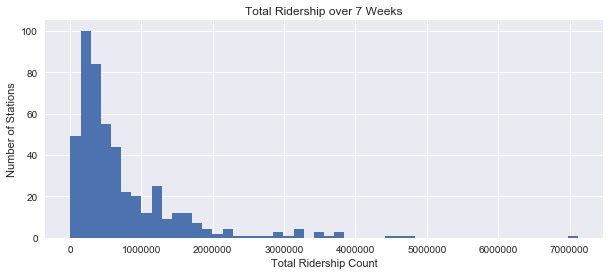

In [114]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(stations_summed['total_traffic'],bins = 50);
ax.set_title('Total Ridership over %s Weeks' % len(weeks))
ax.set_ylabel('Number of Stations')
ax.set_xlabel('Total Ridership Count')

In [115]:
# Its a little weird that 14th St Union square has double the ridership of the other stations
# Investigate 125th St and Broadway station again
top_station_rows = (station_daily['unit'] == 'R170') & (station_daily['station'] == '14 ST-UNION SQ')
top_station = station_daily.loc[(top_station_rows)]

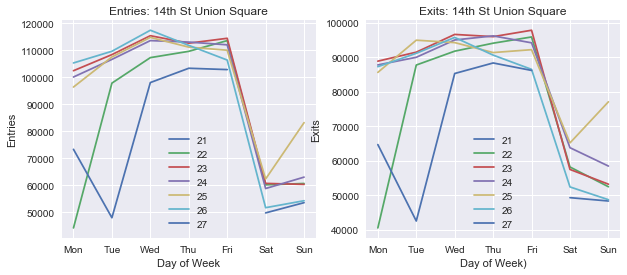

In [116]:
# Plot show no obvious errors. It turns out 42nd st, Times Square is divided into two separate sub-stations,
# but 14th st is not.
make_rainbow_plot(top_station,'14th St Union Square')

# Question 10: Bonus
Bar Chart of 10 busiest stations

In [117]:
xlabs = stations_summed.iloc[0:10]['station_unit']
yvals = stations_summed.iloc[0:10]['total_traffic']
xvals = range(0,len(yvals))

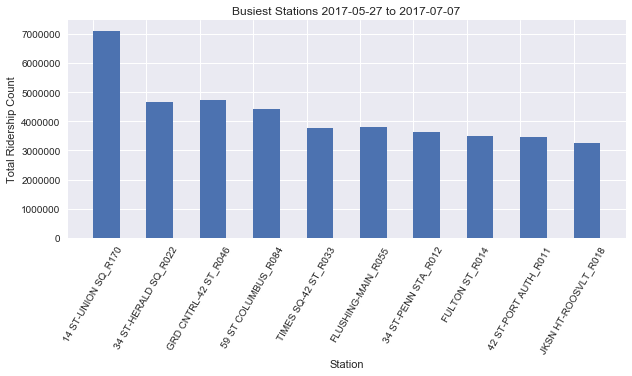

In [127]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(xvals,yvals,
        edgecolor='none',
        width=0.5,
        align='edge',
        label='y1')
ax.set_xticks(xvals);
plt.xticks(rotation = 60)
ax.set_xticklabels(xlabs);
ax.set_xlabel('Station')
ax.set_ylabel('Total Ridership Count')

min_date = str(station_daily['dtime'].min().date())
max_date = str(station_daily['dtime'].max().date())
ax.set_title('Busiest Stations %s to %s' % (min_date,max_date))

# Additional Exploration

#### Lunch and dinner ridership